In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib.request
import requests
from ckonlpy.tag import Twitter
import konlpy.tag
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import networkx as nx
from kornounextractor.noun_extractor import extract
from kr_sna_c import do_kr_sna
from matplotlib import rcParams
import matplotlib.font_manager as fm
import itertools

In [2]:
datawd = 'data\/'

In [3]:
## txt 파일을 사용해서 url과 신문사 정보를 가진 df 생성
Chosun = pd.read_csv(datawd + 'Chosun.txt',header = None)
Donga = pd.read_csv(datawd + 'Donga.txt',header = None)
Hankyoreh = pd.read_csv(datawd + 'Hankyoreh.txt',header = None)
Kyunghyang = pd.read_csv(datawd + 'Kyunghyang.txt',header = None)

Chosun['Corp']='Chosun'
Donga['Corp']='Donga'
Hankyoreh['Corp']='Hankyoreh'
Kyunghyang['Corp']='Kyunghyang'

urlDf = Chosun.append(Donga).append(Hankyoreh).append(Kyunghyang)
urlDf.columns = ['url','corp']
urlDf.index = range(len(urlDf))

In [4]:
# 네이버 뉴스의 기사를 가져오는 함수
def get_text(URL):
    source_code_from_URL = urllib.request.urlopen(URL)
    soup = BeautifulSoup(source_code_from_URL, 'lxml', from_encoding='utf-8')
    news_title = soup.title.text
    publisher = soup.find('meta', attrs={'name':'twitter:creator'}).get('content')
    news_content = soup.find('div', attrs = {'id':'articleBodyContents'}).text
    news_content = news_content.split('{}')[1].strip()
    return news_title, publisher, news_content

In [5]:
## 함수를 사용하여서 기사의 정보를 가져오고 데이터 프레임 생성
atcDf = pd.DataFrame()
atcDf['title']=urlDf.apply(lambda x : get_text(x[0])[0],axis =1)
atcDf['publisher']=urlDf['corp']
atcDf['news_content']=urlDf.apply(lambda x : get_text(x[0])[2],axis =1)

## 정규식을 사용하여 텍스트 전처리, 네트워크 분석을 위한 마침표 콤마 물음표 느낌표는 유지
clDf = pd.DataFrame()
clDf['title']=atcDf.apply(lambda x : re.sub(r'[^\s\d\w\.\?\!\,]','', x['title']),axis =1)
clDf['publisher']=atcDf.apply(lambda x : re.sub(r'[^\s\d\w\.\?\!\,]','', x['publisher']),axis =1)
clDf['news_content'] = atcDf.apply(lambda x : re.sub(r'[^\s\d\w\.\?\!\,]','', x['news_content']),axis =1)

In [22]:
## 전체 신문기사 텍스트 병합
atcl =''
for i in clDf.index:
    atcl= atcl +' ' + clDf['news_content'][i]

In [6]:
## 신문사별 텍스트 병합
nsDict = dict()
for corp in set(clDf['publisher']):
    lst = clDf[clDf['publisher']== corp]['news_content']
    fstr = ''
    for i in lst.index:
        fstr = fstr + ' '+ lst[i]
    nsDict.update({corp : fstr})

In [17]:
##양진호를 나타내는 양 회장이라는 단어를 변경
for i in nsDict.keys():
    nsDict[i]=nsDict[i].replace('양 회장','양진호').replace('양회장','양진호')

In [18]:
## 빈도분석을 위한 함수 생성
def cntWord(text , n = None):
    ## ckonlpy를 이용
    twitter = Twitter()
    ## 사용자 지정 사전 등록 kornounextractor 사용
    for word in sorted(extract(text, freq=2.0)):
        if word == '갑지':
            word ='갑질'
        twitter.add_dictionary(word, 'Noun')

    #twitter.add_dictionary('양진호', 'Noun')
    #twitter.add_dictionary('위디스크', 'Noun')
    #twitter.add_dictionary('한국미래기술', 'Noun')
    #twitter.add_dictionary('헤비업로더', 'Noun')
    
    ## 포스 태깅
    twitter_morphs = twitter.pos(text)
    ## 명사 동사 형용사만 추출
    Noun_words = []
    for word, pos in twitter_morphs:
        if pos == 'Noun' or pos == 'Verb'or pos == 'Adjective':
            Noun_words.append(word)
    ## 불용어 사전을 등록 후 불용어 제거
    stopwords = ['뉴스', '서울','경기' ,'기자','네이버','한겨례','경향신문','동아일보','조선일보','뉴스타파',
                 '한겨레', 'com','성남시','분당구','donga','chosun','kr']
    unique_Noun_words = set(Noun_words)
    for word in unique_Noun_words:
        if word in stopwords:
            while word in Noun_words: Noun_words.remove(word)
    ## 한글자 명사의 경우 뜻을 가진 경우가 많지 않으므로 제거
    for word in unique_Noun_words:
        if len(word)==1:
            while word in Noun_words: 
                Noun_words.remove(word)
    c = Counter(Noun_words)
    if n == None:
        return c.most_common(len(c))
    else:
        return c.most_common(n)

In [19]:
##신문사별
for i in nsDict.keys():
    print(i,'\n',cntWord(nsDict[i],10))

C:\Users\ahn92\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


Chosun 
 [('양진호', 57), ('폭행', 31), ('위디스크', 26), ('했다', 23), ('직원', 22), ('경찰', 20), ('위반', 17), ('영상', 14), ('있다', 14), ('한국미래기술', 13)]
Kyunghyang 
 [('직원', 32), ('양진호', 27), ('했다', 25), ('폭행', 23), ('직장', 21), ('괴롭힘', 20), ('상사', 18), ('폭언', 16), ('갑질', 16), ('있다', 15)]
Hankyoreh 
 [('웹하드', 57), ('업체', 54), ('필터링', 32), ('양진호', 30), ('했다', 26), ('불법', 24), ('직원', 20), ('영상물', 19), ('위디스크', 19), ('폭행', 17)]
Donga 
 [('양진호', 67), ('했다', 51), ('직원', 32), ('폭행', 26), ('위디스크', 19), ('교수', 18), ('사무실', 14), ('영상', 13), ('압수수색', 13), ('경찰', 12)]


C:\Users\ahn92\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


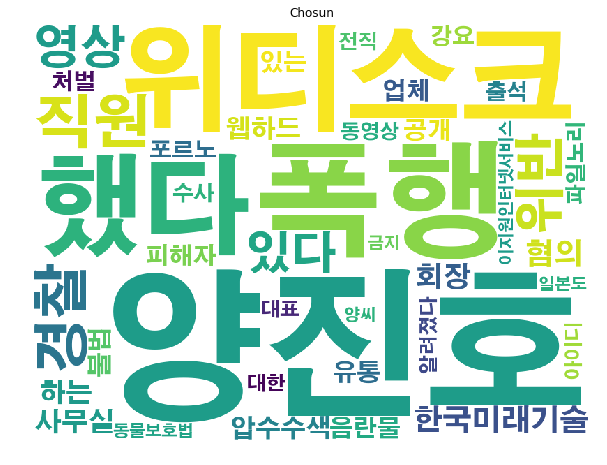

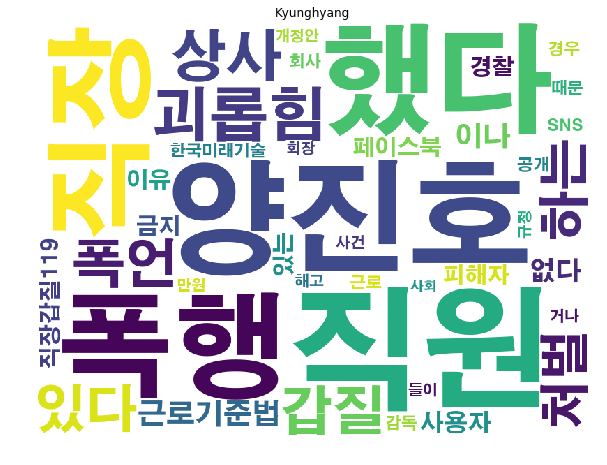

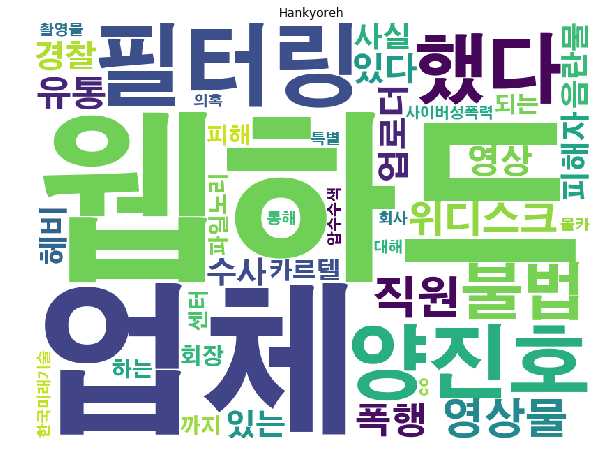

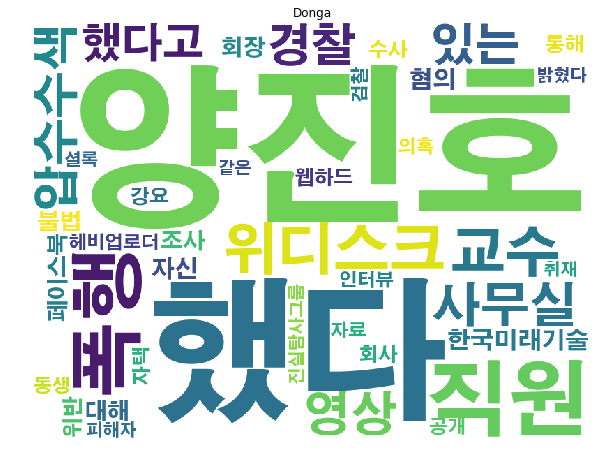

In [20]:
for i in set(clDf['publisher']):
    tags = cntWord(nsDict[i],40)
    font_path = 'C:\Windows\Fonts\H2GTRE.TTF'
    wc = WordCloud(font_path=font_path, background_color='white', width=800, height=600)
    cloud = wc.generate_from_frequencies(dict(tags))
    plt.figure(figsize=(10,8))
    plt.axis('off')
    plt.title(i)
    plt.imshow(cloud)

In [23]:
##네트워크 분석을 시작하기에 앞서 노드를 구성할 단어 선정
##전체 기사에서 높은 빈도를 갖는 단어 탐색
print(cntWord(atcl,40))

C:\Users\ahn92\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


[('회장', 163), ('했다', 125), ('직원', 104), ('폭행', 96), ('웹하드', 75), ('업체', 68), ('위디스크', 68), ('양진호', 53), ('경찰', 53), ('영상', 45), ('불법', 45), ('있다', 45), ('있는', 41), ('하는', 40), ('한국미래기술', 38), ('피해자', 34), ('위반', 33), ('사무실', 32), ('압수수색', 32), ('유통', 32), ('필터링', 32), ('처벌', 28), ('수사', 27), ('공개', 25), ('혐의', 25), ('음란물', 25), ('회사', 25), ('금지', 24), ('영상물', 24), ('직장', 24), ('대해', 22), ('대한', 21), ('파일노리', 21), ('괴롭힘', 21), ('폭언', 20), ('재배포', 20), ('들이', 20), ('교수', 20), ('업로더', 20), ('지난', 19)]


In [24]:
## 네트워크의 노드를 구성할 단어 선택
name = ['양진호']
gabzil = ['갑질','괴롭힘','상사']
corp = ['위디스크','영상','음란물', '불법']
susa = ['수사', '압수수색', '검찰', '경찰','폭행']
#list_of_words = ['폭행','수사','양진호','압수수색','갑질','음란물','영상','괴롭힘','위디스크',
#                 '불법','검찰','경찰']
list_of_words = name + gabzil + corp + susa

In [25]:
def netwk(content, sword):
    stopwords = ['뉴스', '서울','경기' ,'기자','네이버','한겨례','경향신문','동아일보','조선일보','뉴스타파','한겨레','.com']
    
    ##사용자사전 생성
    with open('usrdic/dic.txt', 'w', encoding='utf8') as f:
        for word in sorted(extract(content, freq=2.0)):
            # kornounextracter에서 '갑질'단어를 '갑지'로 변경하는 부분 수정
            if word == '갑지':
                f.write('갑질'+'\tNNG\n')
            else:
                f.write(word+'\tNNG\n')
    
    komoran = konlpy.tag.Komoran(userdic='usrdic/dic.txt')
    
    Nouns = komoran.nouns(content)
    final_nouns = Nouns.copy()
    unique_nouns = set(Nouns)
    
    for word in unique_nouns:
        if len(word) == 1:
            while word in final_nouns:
                final_nouns.remove(word)
        if word in stopwords:
            while word in final_nouns:
                final_nouns.remove(word)
                
    g = do_kr_sna(content, final_nouns, stopwords,list_of_words = list_of_words, userdic= False)
    
    yghDict = dict(g[sword])
    
    cntlst = []
    for k in yghDict.keys():
        cntlst.append([k,yghDict[k]['weight']])
    
    return sorted(cntlst, key= lambda x : -x[1])

In [26]:
## 모든 신문사에 대해
#netwk(atcl,'양진호')

In [27]:
for i in nsDict.keys():
    print(i,'\n',netwk(nsDict[i],'양진호'))

Chosun 
 [['폭행', 21], ['위디스크', 16], ['경찰', 10], ['영상', 5], ['불법', 4], ['압수수색', 4], ['음란물', 4], ['수사', 2]]
Kyunghyang 
 [['폭행', 9], ['갑질', 6], ['경찰', 4], ['위디스크', 3], ['영상', 3], ['괴롭힘', 2], ['상사', 1], ['압수수색', 1], ['수사', 1], ['음란물', 1], ['불법', 1]]
Hankyoreh 
 [['폭행', 10], ['위디스크', 9], ['불법', 8], ['경찰', 7], ['음란물', 4], ['수사', 4], ['영상', 4], ['압수수색', 1], ['검찰', 1]]
Donga 
 [['폭행', 21], ['위디스크', 11], ['영상', 9], ['압수수색', 9], ['경찰', 9], ['수사', 6], ['불법', 5], ['검찰', 4], ['음란물', 3]]


In [28]:
def plotntw(content):
    stopwords = ['뉴스', '서울','경기' ,'기자','네이버','한겨례','경향신문','동아일보','조선일보','뉴스타파','한겨레','.com']
    
    with open('usrdic/dic.txt', 'w', encoding='utf8') as f:
        for word in sorted(extract(content, freq=2.0)):
            if word == '갑지':
                f.write('갑질'+'\tNNG\n')
            else:
                f.write(word+'\tNNG\n')
                
    komoran = konlpy.tag.Komoran(userdic='usrdic/dic.txt')
    
    Nouns = komoran.nouns(content)
    final_nouns = Nouns.copy()
    unique_nouns = set(Nouns)
    
    for word in unique_nouns:
        if len(word) == 1:
            while word in final_nouns:
                final_nouns.remove(word)
        if word in stopwords:
            while word in final_nouns:
                final_nouns.remove(word)
                
    g = do_kr_sna(content, final_nouns, stopwords, list_of_words=list_of_words, userdic = False)    

    rcParams['font.family'] = 'Noto Sans Korean'
    font_name = 'Malgun Gothic'
    pos=nx.shell_layout(g)
    nx.draw(g, pos)
    nx.draw_networkx_labels(g, pos, font_family=font_name, font_size=10)

    plt.show()

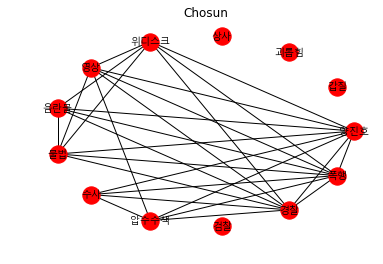

C:\Users\ahn92\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Noto Sans Korean'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


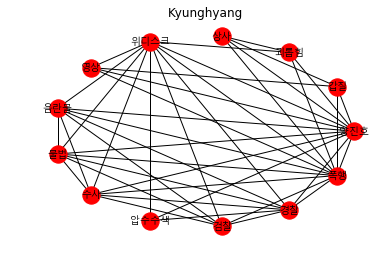

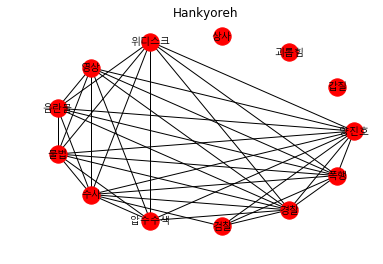

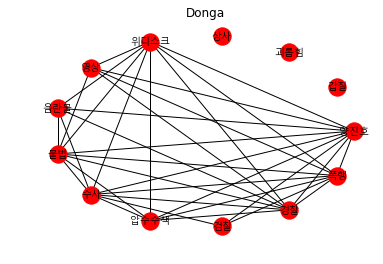

In [29]:
for i in nsDict.keys():
    plt.title(i)
    plotntw(nsDict[i])

In [30]:
def outG(content):
    stopwords = ['뉴스', '서울','경기' ,'기자','네이버','한겨례','경향신문','동아일보','조선일보','뉴스타파','한겨레','.com']
    
    ##사용자사전 생성
    with open('usrdic/dic.txt', 'w', encoding='utf8') as f:
        for word in sorted(extract(content, freq=2.0)):
            # kornounextracter에서 '갑질'단어를 '갑지'로 변경하는 부분 수정
            if word == '갑지':
                f.write('갑질'+'\tNNG\n')
            else:
                f.write(word+'\tNNG\n')
    
    komoran = konlpy.tag.Komoran(userdic='usr/dic.txt')
    
    Nouns = komoran.nouns(content)
    final_nouns = Nouns.copy()
    unique_nouns = set(Nouns)
    
    for word in unique_nouns:
        if len(word) == 1:
            while word in final_nouns:
                final_nouns.remove(word)
        if word in stopwords:
            while word in final_nouns:
                final_nouns.remove(word)
                
    g = do_kr_sna(content, final_nouns, stopwords, list_of_words = list_of_words, userdic= False)
    return g

In [31]:
g_kh = outG(nsDict['Kyunghyang'])
g_hgr = outG(nsDict['Hankyoreh']) 
g_da = outG(nsDict['Donga'])
g_cs = outG(nsDict['Chosun'])

In [32]:
nx.write_gml(g_kh, 'graphml/g_ky.gml')
nx.write_gml(g_hgr, 'graphml/g_ha.gml')
nx.write_gml(g_da, 'graphml/g_do.gml')
nx.write_gml(g_cs, 'graphml/g_ch.gml')

In [33]:
nx.write_graphml(g_kh, 'graphml/g_ky.graphml')
nx.write_graphml(g_hgr, 'graphml/g_ha.graphml')
nx.write_graphml(g_da, 'graphml/g_do.graphml')
nx.write_graphml(g_cs, 'graphml/g_ch.graphml')